In [13]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import load_files
import models
from load_files import *
from models import *


In [15]:
x_train, y_train, x_test, y_test = load_dataset('../data/HAR/UCI_HAR_Dataset/')

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [29]:
y_train

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [16]:
x_train.shape

(7352, 128, 9)

In [17]:
n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]

keras imports

In [18]:
from keras import Model
from keras.layers import Lambda, Input, Dropout, Flatten, LSTM, Concatenate, Bidirectional, Conv1D
from keras import backend as K
from keras.callbacks import TensorBoard
from time import time
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from time import time

# Model generators

here we are going to analyse the performance of diffierent methods to classify the time series

here we define recall and auc metrics that are not implemented in keras

references:

https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras

In [19]:
import custom_metrics; from custom_metrics import as_keras_metric
import tensorflow as tf

auc_roc = as_keras_metric(tf.metrics.auc)
recall = as_keras_metric(tf.metrics.recall)

## Some callbacks

we define some callbacks that we are going to implement during training

https://stackoverflow.com/questions/50874596/how-to-detect-the-epoch-where-keras-earlystopping-occurred

In [20]:
#lr_cb = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, min_delta = 0.01, patience = 3, verbose = 1)
#es_cb = EarlyStopping(monitor = 'val_loss', min_delta=0.01, patience = 10, verbose = 1, restore_best_weights = True)

min_delta_val = 0.01
lr_cb = ReduceLROnPlateau(monitor = 'val_auc', mode='max', 
                          factor = 0.5, min_delta = min_delta_val, patience = 3, verbose = 1)
es_cb = EarlyStopping(monitor = 'val_auc', mode='max', 
                      min_delta=min_delta_val, patience = 10, verbose = 1, restore_best_weights = True)

default_callbacks = [lr_cb, es_cb]

Training parameters

In [21]:
from keras import optimizers

In [22]:
N_train = 3
adam = optimizers.adam(lr=0.01)
validation_split_on_training = 0.2
epochs = 60
batch_size = 250

In [23]:
import models; from models import *

def generate_trained_models(model_type):
    
    print_summary_only_once = True
    trained_models = []
    trained_models_best_epoch = []
    trained_models_stats = []
    trained_models_time_taken = []

    model_name_base = model_type

    if model_type =='dense_2':
        model_generator = dense_1d_2_model_generator
    elif model_type =='LSTM_2':
        model_generator = lstm_model_2_generator
    elif model_type =='dense':
        model_generator = dense_1d_model_generator
    elif model_type =='LSTM':
        model_generator = lstm_model_generator
    elif model_type =='ens':
        model_generator = hybrid_ens_generator
    elif model_type =='dense_fc':
        model_generator = dense_fully_connected_model_generator        
    elif model_type =='conv_1d':
        model_generator = conv_1d_model_generator                
    else:
        raise ValueError('No model type found')
    
        
    for i in range(N_train):
        tic = time()
        model_name = model_name_base + '_' + str(i)
        tensorboard = TensorBoard(log_dir="logs/{}".format(model_name + '_' + str(time())))
        callbacks_model = default_callbacks + [tensorboard]

        # generate model
        model_input, model_output , _ = model_generator(n_timesteps, n_features, n_outputs)
        model = Model(model_input, model_output, name = model_name)

        #compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', auc_roc, recall])
        if print_summary_only_once:
            model.summary()
            print_summary_only_once = False

        # train model
        model.fit(x_train, 
                  y_train, epochs=epochs, 
                  batch_size=batch_size, 
                  validation_split=validation_split_on_training,
                  verbose=True,
                  shuffle=True,
                  callbacks = callbacks_model)     
        trained_models.append(model)

        # training time
        training_time = time()-tic
        trained_models_time_taken.append(training_time)
        print('training time: {}s'.format(training_time))

        # early stopping epoch
        best_epoch = es_cb.stopped_epoch
        trained_models_best_epoch.append(best_epoch)

        #append best stat
        best_stats = {}
        for key in model.history.history.keys():
            best_stats[key] = model.history.history[key][best_epoch]
        trained_models_stats.append(best_stats)
    
    trained_models_stats = pd.DataFrame(trained_models_stats)
    return trained_models, trained_models_stats, trained_models_time_taken, trained_models_best_epoch

In [25]:
#model_types = [ 'LSTM_2','LSTM', 'dense_2','dense', 'ens', 'dense_fc','conv_1d']
model_types = [ 'LSTM', 'dense_2','dense', 'ens', 'dense_fc','conv_1d']
#model_types = ['conv_1d', 'LSTM_2']
trainig_reulsts = {}

for model_name in model_types:
    
    trained_models, trained_models_stats, trained_models_time_taken, trained_models_best_epoch = generate_trained_models(model_name)
    stats_best_epoch = pd.DataFrame(trained_models_best_epoch, columns=['epoch']).mean()
    stats_time_takes = pd.DataFrame(trained_models_time_taken, columns=['time']).mean()
    stats_best_stats = pd.DataFrame(trained_models_stats).mean()

    trainig_reulsts[model_name] = {'trained_models': trained_models,
                                  'trained_models_stats': trained_models_stats,
                                  'trained_models_time_taken': trained_models_time_taken,
                                  'trained_models_best_epoch': trained_models_best_epoch,
                                  'stats_best_epoch': stats_best_epoch,
                                  'stats_time_takes': stats_time_takes,
                                  'stats_best_stats': stats_best_stats}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 9)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 150)               96000     
_________________________________________________________________
dropout_5 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 150)               22650     
_________________________________________________________________
lstm_out (Dense)             (None, 6)                 906       
Total params: 119,556
Trainable params: 119,556
Non-trainable params: 0
_________________________________________________________________
Train on 5881 samples, validate on 1471 samples
Epoch 1/60
5881/5881 [==============================] - 8s 1ms/step - loss: 1.7962 - acc

5881/5881 [==============================] - 6s 1ms/step - loss: 0.4488 - acc: 0.8298 - auc: 0.9510 - recall: 0.9936 - val_loss: 0.5852 - val_acc: 0.8137 - val_auc: 0.9515 - val_recall: 0.9937
Epoch 35/60
5881/5881 [==============================] - 6s 1ms/step - loss: 0.4472 - acc: 0.8289 - auc: 0.9519 - recall: 0.9938 - val_loss: 0.5702 - val_acc: 0.8205 - val_auc: 0.9524 - val_recall: 0.9939
Epoch 36/60
5881/5881 [==============================] - 6s 1ms/step - loss: 0.4604 - acc: 0.8369 - auc: 0.9528 - recall: 0.9939 - val_loss: 0.5676 - val_acc: 0.8199 - val_auc: 0.9532 - val_recall: 0.9940
Epoch 37/60
5881/5881 [==============================] - 6s 1ms/step - loss: 0.4419 - acc: 0.8335 - auc: 0.9536 - recall: 0.9941 - val_loss: 0.5685 - val_acc: 0.8246 - val_auc: 0.9540 - val_recall: 0.9941

Epoch 00037: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 38/60
5881/5881 [==============================] - 6s 1ms/step - loss: 0.4410 - acc: 0.8363 - auc: 0.9543

Epoch 27/60
5881/5881 [==============================] - 7s 1ms/step - loss: 0.3937 - acc: 0.8815 - auc: 0.9375 - recall: 0.9709 - val_loss: 0.4696 - val_acc: 0.8464 - val_auc: 0.9386 - val_recall: 0.9713
Epoch 28/60
5881/5881 [==============================] - 6s 1ms/step - loss: 0.3710 - acc: 0.8796 - auc: 0.9396 - recall: 0.9718 - val_loss: 0.4686 - val_acc: 0.8511 - val_auc: 0.9406 - val_recall: 0.9722

Epoch 00028: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 29/60
5881/5881 [==============================] - 7s 1ms/step - loss: 0.3675 - acc: 0.8832 - auc: 0.9416 - recall: 0.9726 - val_loss: 0.4698 - val_acc: 0.8443 - val_auc: 0.9425 - val_recall: 0.9730
Epoch 30/60
5881/5881 [==============================] - 7s 1ms/step - loss: 0.3985 - acc: 0.8789 - auc: 0.9433 - recall: 0.9733 - val_loss: 0.4692 - val_acc: 0.8504 - val_auc: 0.9442 - val_recall: 0.9737
Epoch 31/60
5881/5881 [==============================] - 6s 1ms/step - loss: 0.3900 - acc: 0.8806 - 

5881/5881 [==============================] - 6s 1ms/step - loss: 1.3587 - acc: 0.7988 - auc: 0.9413 - recall: 0.9872 - val_loss: 1.9574 - val_acc: 0.7553 - val_auc: 0.9402 - val_recall: 0.9844
Epoch 15/60
5881/5881 [==============================] - 6s 1ms/step - loss: 0.7421 - acc: 0.8522 - auc: 0.9409 - recall: 0.9835 - val_loss: 0.7738 - val_acc: 0.7831 - val_auc: 0.9420 - val_recall: 0.9835
Epoch 16/60
5881/5881 [==============================] - 6s 1ms/step - loss: 0.3771 - acc: 0.8704 - auc: 0.9432 - recall: 0.9840 - val_loss: 0.5116 - val_acc: 0.8552 - val_auc: 0.9449 - val_recall: 0.9845
Epoch 17/60
5881/5881 [==============================] - 6s 1ms/step - loss: 0.2796 - acc: 0.8961 - auc: 0.9465 - recall: 0.9850 - val_loss: 0.5321 - val_acc: 0.8742 - val_auc: 0.9481 - val_recall: 0.9854
Epoch 18/60
5881/5881 [==============================] - 6s 1ms/step - loss: 0.2549 - acc: 0.9058 - auc: 0.9496 - recall: 0.9858 - val_loss: 0.5929 - val_acc: 0.8865 - val_auc: 0.9510 - val_re

Train on 5881 samples, validate on 1471 samples
Epoch 1/60
5881/5881 [==============================] - 1s 230us/step - loss: 1.0672 - acc: 0.5707 - auc: 0.7505 - recall: 0.9575 - val_loss: 0.5765 - val_acc: 0.7825 - val_auc: 0.9027 - val_recall: 1.0000
Epoch 2/60
5881/5881 [==============================] - 0s 57us/step - loss: 0.4546 - acc: 0.8140 - auc: 0.9310 - recall: 1.0000 - val_loss: 0.4610 - val_acc: 0.8443 - val_auc: 0.9482 - val_recall: 1.0000
Epoch 3/60
5881/5881 [==============================] - 0s 53us/step - loss: 0.3040 - acc: 0.8876 - auc: 0.9581 - recall: 1.0000 - val_loss: 0.4041 - val_acc: 0.8668 - val_auc: 0.9654 - val_recall: 1.0000
Epoch 4/60
5881/5881 [==============================] - 0s 52us/step - loss: 0.2421 - acc: 0.9097 - auc: 0.9701 - recall: 1.0000 - val_loss: 0.3532 - val_acc: 0.8933 - val_auc: 0.9739 - val_recall: 1.0000
Epoch 5/60
5881/5881 [==============================] - 0s 51us/step - loss: 0.1989 - acc: 0.9218 - auc: 0.9767 - recall: 1.0000 - 

5881/5881 [==============================] - 0s 56us/step - loss: 0.0807 - acc: 0.9641 - auc: 0.9925 - recall: 1.0000 - val_loss: 0.3174 - val_acc: 0.9252 - val_auc: 0.9927 - val_recall: 1.0000

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 18/60
5881/5881 [==============================] - 0s 57us/step - loss: 0.0763 - acc: 0.9655 - auc: 0.9928 - recall: 1.0000 - val_loss: 0.3266 - val_acc: 0.9273 - val_auc: 0.9929 - val_recall: 1.0000
Epoch 19/60
5881/5881 [==============================] - 0s 56us/step - loss: 0.0774 - acc: 0.9650 - auc: 0.9930 - recall: 1.0000 - val_loss: 0.3251 - val_acc: 0.9259 - val_auc: 0.9931 - val_recall: 1.0000
Epoch 20/60
5881/5881 [==============================] - 0s 55us/step - loss: 0.0774 - acc: 0.9677 - auc: 0.9932 - recall: 1.0000 - val_loss: 0.3271 - val_acc: 0.9259 - val_auc: 0.9932 - val_recall: 1.0000

Epoch 00020: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 21/60
5881/5881 [====

Train on 5881 samples, validate on 1471 samples
Epoch 1/60
5881/5881 [==============================] - 1s 241us/step - loss: 1.2196 - acc: 0.5278 - auc: 0.7142 - recall: 0.9575 - val_loss: 0.7363 - val_acc: 0.6594 - val_auc: 0.8762 - val_recall: 1.0000
Epoch 2/60
5881/5881 [==============================] - 0s 47us/step - loss: 0.5611 - acc: 0.7676 - auc: 0.9109 - recall: 1.0000 - val_loss: 0.5054 - val_acc: 0.8178 - val_auc: 0.9333 - val_recall: 1.0000
Epoch 3/60
5881/5881 [==============================] - 0s 49us/step - loss: 0.3658 - acc: 0.8594 - auc: 0.9458 - recall: 1.0000 - val_loss: 0.4145 - val_acc: 0.8776 - val_auc: 0.9552 - val_recall: 1.0000
Epoch 4/60
5881/5881 [==============================] - 0s 50us/step - loss: 0.2778 - acc: 0.8944 - auc: 0.9615 - recall: 1.0000 - val_loss: 0.3648 - val_acc: 0.8912 - val_auc: 0.9666 - val_recall: 1.0000
Epoch 5/60
5881/5881 [==============================] - 0s 50us/step - loss: 0.2408 - acc: 0.9121 - auc: 0.9702 - recall: 1.0000 - 

5881/5881 [==============================] - 0s 50us/step - loss: 0.1111 - acc: 0.9573 - auc: 0.9908 - recall: 1.0000 - val_loss: 0.2933 - val_acc: 0.9239 - val_auc: 0.9910 - val_recall: 1.0000
Epoch 16/60
5881/5881 [==============================] - 0s 50us/step - loss: 0.1109 - acc: 0.9568 - auc: 0.9912 - recall: 1.0000 - val_loss: 0.2889 - val_acc: 0.9259 - val_auc: 0.9914 - val_recall: 1.0000

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 17/60
5881/5881 [==============================] - 0s 50us/step - loss: 0.1077 - acc: 0.9570 - auc: 0.9915 - recall: 1.0000 - val_loss: 0.2911 - val_acc: 0.9252 - val_auc: 0.9917 - val_recall: 1.0000
Epoch 18/60
5881/5881 [==============================] - 0s 50us/step - loss: 0.1127 - acc: 0.9539 - auc: 0.9918 - recall: 1.0000 - val_loss: 0.2873 - val_acc: 0.9266 - val_auc: 0.9919 - val_recall: 1.0000
Epoch 19/60
5881/5881 [==============================] - 0s 50us/step - loss: 0.1063 - acc: 0.9583 - auc: 0

Train on 5881 samples, validate on 1471 samples
Epoch 1/60
5881/5881 [==============================] - 8s 1ms/step - loss: 1.3059 - acc: 0.5681 - auc: 0.7149 - recall: 0.9563 - val_loss: 0.7424 - val_acc: 0.7492 - val_auc: 0.8863 - val_recall: 0.9941
Epoch 2/60
5881/5881 [==============================] - 7s 1ms/step - loss: 1.4624 - acc: 0.7665 - auc: 0.9065 - recall: 0.9835 - val_loss: 2.2352 - val_acc: 0.7308 - val_auc: 0.9088 - val_recall: 0.9660
Epoch 3/60
5881/5881 [==============================] - 7s 1ms/step - loss: 0.7670 - acc: 0.8473 - auc: 0.9171 - recall: 0.9633 - val_loss: 2.0506 - val_acc: 0.7349 - val_auc: 0.9267 - val_recall: 0.9643
Epoch 4/60
5881/5881 [==============================] - 7s 1ms/step - loss: 0.4437 - acc: 0.8898 - auc: 0.9318 - recall: 0.9637 - val_loss: 0.4475 - val_acc: 0.8559 - val_auc: 0.9405 - val_recall: 0.9680
Epoch 5/60
5881/5881 [==============================] - 7s 1ms/step - loss: 0.2651 - acc: 0.9146 - auc: 0.9468 - recall: 0.9713 - val_lo

Epoch 17/60
5881/5881 [==============================] - 6s 1ms/step - loss: 0.1097 - acc: 0.9573 - auc: 0.9907 - recall: 0.9979 - val_loss: 0.2921 - val_acc: 0.9089 - val_auc: 0.9909 - val_recall: 0.9980

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 18/60
5881/5881 [==============================] - 7s 1ms/step - loss: 0.1106 - acc: 0.9589 - auc: 0.9911 - recall: 0.9980 - val_loss: 0.3015 - val_acc: 0.9089 - val_auc: 0.9912 - val_recall: 0.9981
Epoch 19/60
5881/5881 [==============================] - 6s 1ms/step - loss: 0.1079 - acc: 0.9568 - auc: 0.9914 - recall: 0.9981 - val_loss: 0.2955 - val_acc: 0.9157 - val_auc: 0.9915 - val_recall: 0.9982
Epoch 20/60
5881/5881 [==============================] - 7s 1ms/step - loss: 0.1070 - acc: 0.9568 - auc: 0.9916 - recall: 0.9982 - val_loss: 0.2934 - val_acc: 0.9164 - val_auc: 0.9918 - val_recall: 0.9983

Epoch 00020: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 21/60
5881/58

5881/5881 [==============================] - 3s 568us/step - loss: 0.2351 - acc: 0.9155 - auc: 0.9713 - recall: 1.0000 - val_loss: 0.6875 - val_acc: 0.8838 - val_auc: 0.9734 - val_recall: 1.0000
Epoch 7/60
5881/5881 [==============================] - 3s 572us/step - loss: 0.1891 - acc: 0.9337 - auc: 0.9752 - recall: 1.0000 - val_loss: 0.7050 - val_acc: 0.8749 - val_auc: 0.9767 - val_recall: 1.0000
Epoch 8/60
5881/5881 [==============================] - 3s 575us/step - loss: 0.1890 - acc: 0.9281 - auc: 0.9778 - recall: 1.0000 - val_loss: 0.6712 - val_acc: 0.8939 - val_auc: 0.9789 - val_recall: 1.0000

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 9/60
5881/5881 [==============================] - 3s 569us/step - loss: 0.1502 - acc: 0.9434 - auc: 0.9799 - recall: 1.0000 - val_loss: 0.6574 - val_acc: 0.9069 - val_auc: 0.9809 - val_recall: 1.0000
Epoch 10/60
5881/5881 [==============================] - 3s 571us/step - loss: 0.1367 - acc: 0.9449 - auc:

Epoch 3/60
5881/5881 [==============================] - 3s 564us/step - loss: 0.3983 - acc: 0.8417 - auc: 0.9429 - recall: 1.0000 - val_loss: 0.6373 - val_acc: 0.8389 - val_auc: 0.9515 - val_recall: 1.0000
Epoch 4/60
5881/5881 [==============================] - 3s 565us/step - loss: 0.3223 - acc: 0.8777 - auc: 0.9573 - recall: 1.0000 - val_loss: 0.6238 - val_acc: 0.8647 - val_auc: 0.9620 - val_recall: 1.0000
Epoch 5/60
5881/5881 [==============================] - 3s 563us/step - loss: 0.2777 - acc: 0.8953 - auc: 0.9654 - recall: 1.0000 - val_loss: 0.6893 - val_acc: 0.8688 - val_auc: 0.9682 - val_recall: 1.0000
Epoch 6/60
5881/5881 [==============================] - 3s 563us/step - loss: 0.2332 - acc: 0.9114 - auc: 0.9706 - recall: 1.0000 - val_loss: 0.6565 - val_acc: 0.8960 - val_auc: 0.9727 - val_recall: 1.0000
Epoch 7/60
5881/5881 [==============================] - 3s 564us/step - loss: 0.1783 - acc: 0.9376 - auc: 0.9747 - recall: 1.0000 - val_loss: 0.6742 - val_acc: 0.9041 - val_auc

5881/5881 [==============================] - 2s 397us/step - loss: 0.0853 - acc: 0.9609 - auc: 0.9907 - recall: 1.0000 - val_loss: 0.3462 - val_acc: 0.9205 - val_auc: 0.9909 - val_recall: 1.0000
Epoch 12/60
5881/5881 [==============================] - 2s 398us/step - loss: 0.0866 - acc: 0.9600 - auc: 0.9912 - recall: 1.0000 - val_loss: 0.3406 - val_acc: 0.9279 - val_auc: 0.9914 - val_recall: 1.0000
Epoch 13/60
5881/5881 [==============================] - 2s 397us/step - loss: 0.0822 - acc: 0.9628 - auc: 0.9916 - recall: 1.0000 - val_loss: 0.3396 - val_acc: 0.9225 - val_auc: 0.9918 - val_recall: 1.0000

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 14/60
5881/5881 [==============================] - 2s 396us/step - loss: 0.0812 - acc: 0.9633 - auc: 0.9920 - recall: 1.0000 - val_loss: 0.3580 - val_acc: 0.9205 - val_auc: 0.9921 - val_recall: 1.0000
Epoch 15/60
5881/5881 [==============================] - 2s 401us/step - loss: 0.0813 - acc: 0.9634 - a

5881/5881 [==============================] - 2s 401us/step - loss: 0.0680 - acc: 0.9646 - auc: 0.9932 - recall: 1.0000 - val_loss: 0.4969 - val_acc: 0.9191 - val_auc: 0.9932 - val_recall: 1.0000
Epoch 15/60
5881/5881 [==============================] - 2s 401us/step - loss: 0.0682 - acc: 0.9650 - auc: 0.9933 - recall: 1.0000 - val_loss: 0.5054 - val_acc: 0.9137 - val_auc: 0.9934 - val_recall: 1.0000

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 16/60
5881/5881 [==============================] - 2s 405us/step - loss: 0.0665 - acc: 0.9662 - auc: 0.9935 - recall: 1.0000 - val_loss: 0.5096 - val_acc: 0.9184 - val_auc: 0.9935 - val_recall: 1.0000
Restoring model weights from the end of the best epoch
Epoch 00016: early stopping
training time: 61.258931398391724s


_____
model: LSTM 

mean best epoc: [40.]
mean training time: [275.56412427]
STATS:
acc           0.865216
auc           0.959082
loss          0.676688
lr            0.000014
recall        0.984079
val_acc       0.852708
val_auc       0.959223
val_loss      0.689645
val_recall    0.983930
dtype: float64




<IPython.core.display.Javascript object>


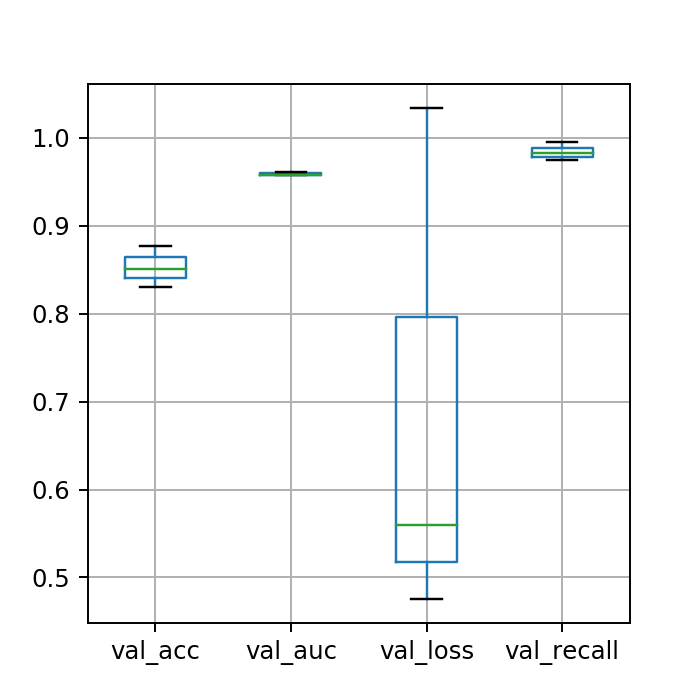

_____
model: dense_2 

mean best epoc: [20.33333333]
mean training time: [19.49054233]
STATS:
acc           0.966106
auc           0.993378
loss          0.077036
lr            0.000052
recall        1.000000
val_acc       0.926807
val_auc       0.993440
val_loss      0.321176
val_recall    1.000000
dtype: float64




<IPython.core.display.Javascript object>


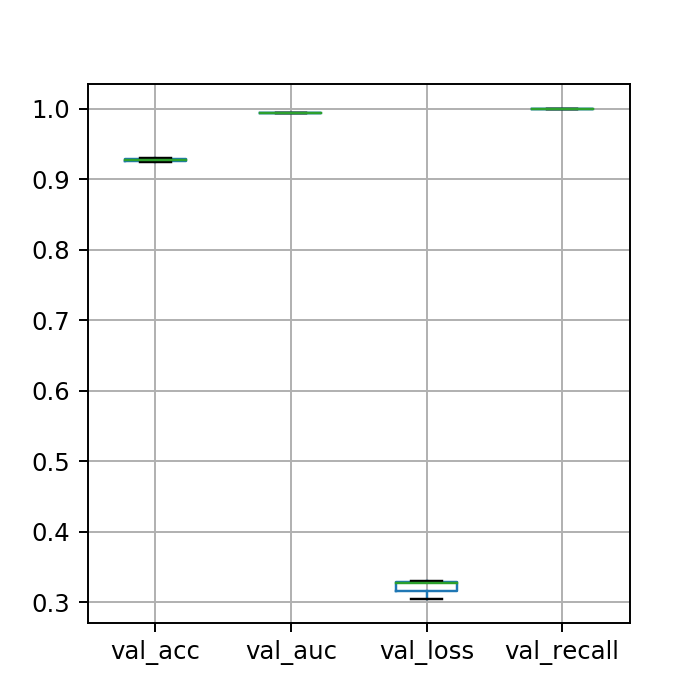

_____
model: dense 

mean best epoc: [20.66666667]
mean training time: [21.13987708]
STATS:
acc           0.957207
auc           0.991995
loss          0.106021
lr            0.000052
recall        1.000000
val_acc       0.915250
val_auc       0.992079
val_loss      0.321964
val_recall    1.000000
dtype: float64




<IPython.core.display.Javascript object>


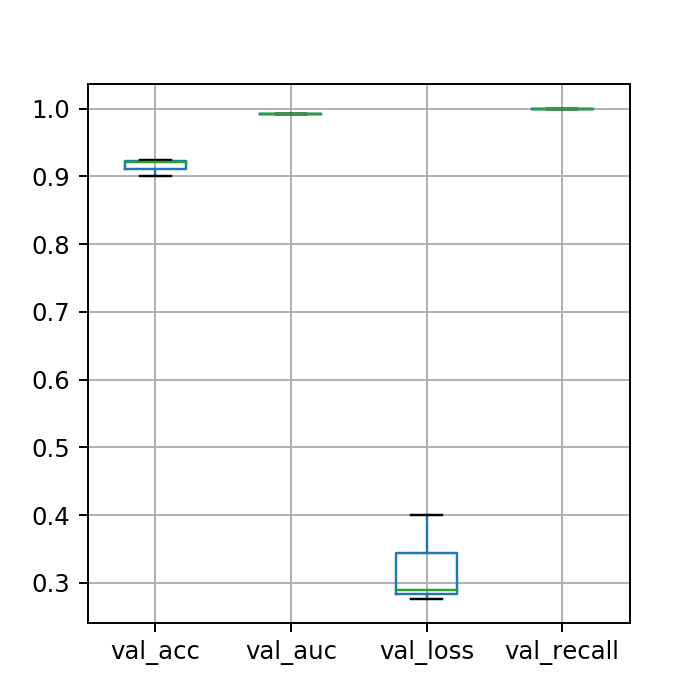

_____
model: ens 

mean best epoc: [19.33333333]
mean training time: [153.17728448]
STATS:
acc           0.957093
auc           0.989579
loss          0.111965
lr            0.000063
recall        0.996432
val_acc       0.905280
val_auc       0.989751
val_loss      0.310829
val_recall    0.996519
dtype: float64




<IPython.core.display.Javascript object>


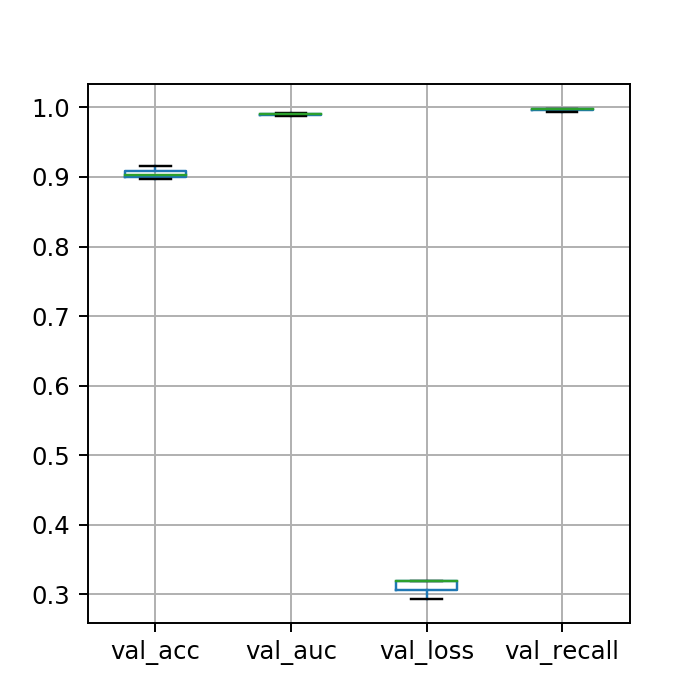

_____
model: dense_fc 

mean best epoc: [18.66666667]
mean training time: [86.19546501]
STATS:
acc           0.958680
auc           0.988381
loss          0.101426
lr            0.000063
recall        1.000000
val_acc       0.907999
val_auc       0.988512
val_loss      0.669495
val_recall    1.000000
dtype: float64




<IPython.core.display.Javascript object>


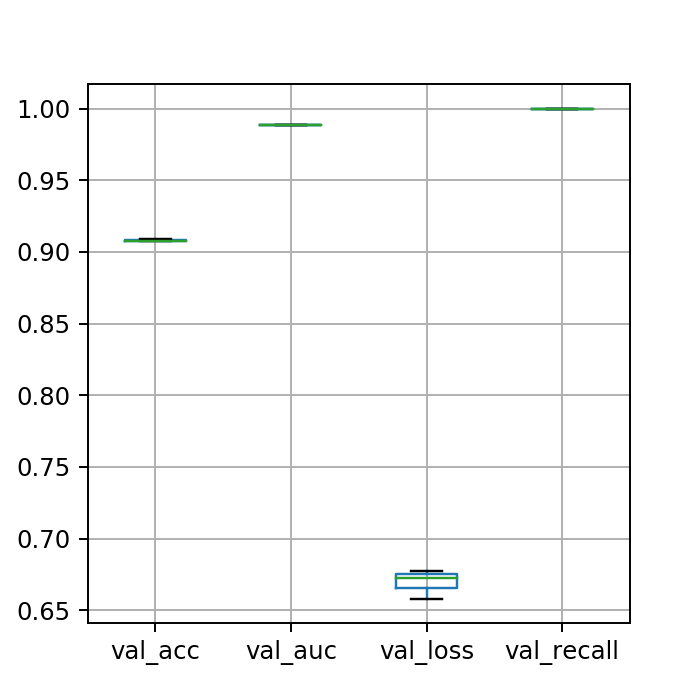

_____
model: conv_1d 

mean best epoc: [15.]
mean training time: [59.80732369]
STATS:
acc           0.964292
auc           0.993495
loss          0.074132
lr            0.000125
recall        1.000000
val_acc       0.915024
val_auc       0.993533
val_loss      0.397048
val_recall    1.000000
dtype: float64




<IPython.core.display.Javascript object>


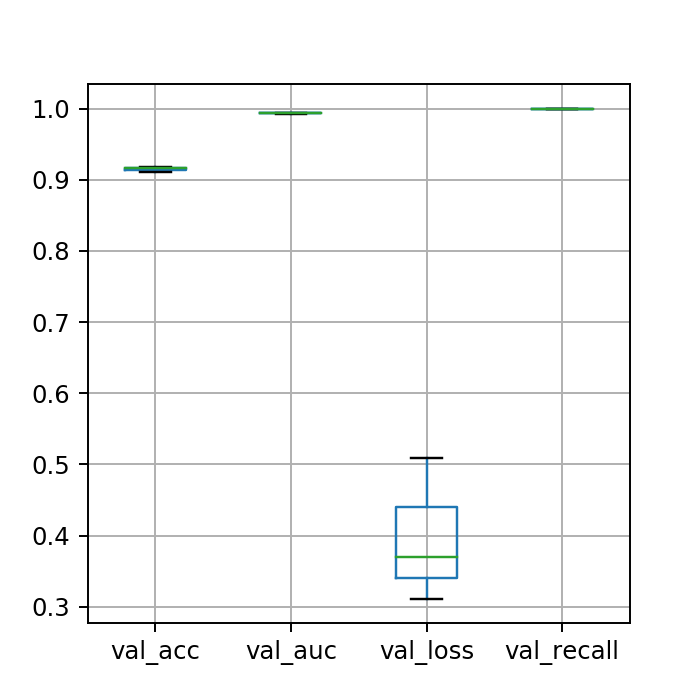

In [26]:
for model_name in trainig_reulsts.keys():
    print('_____')
    print('model: {} \n'.format(model_name))
    print('mean best epoc: {}'.format(trainig_reulsts[model_name]['stats_best_epoch'].values))
    print('mean training time: {}'.format(trainig_reulsts[model_name]['stats_time_takes'].values))
    
    print('STATS:')
    
    print(trainig_reulsts[model_name]['stats_best_stats'])
    print('\n')

    plt.figure(figsize = (4,4))
    stats_for_model = trainig_reulsts[model_name]['trained_models_stats']
    stats_for_model[stats_for_model.columns[stats_for_model.columns.str.contains(pat = 'val')]].boxplot()
    

In [27]:
stats_for_model[['val_auc']].values.ravel()

array([0.9927354 , 0.99437265, 0.99348999])

<IPython.core.display.Javascript object>


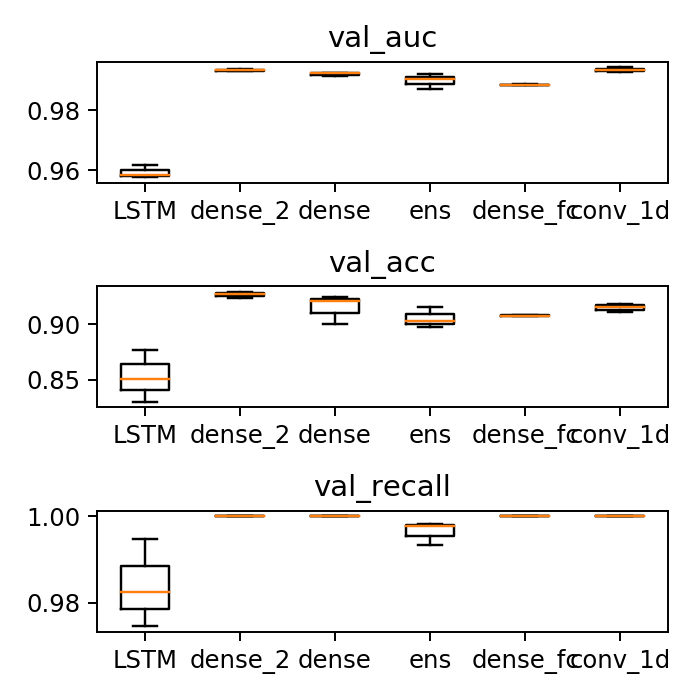

val_auc
LSTM	0.9592231799355174
dense_2	0.9934404347587437
dense	0.992079216081108
ens	0.9897511921689647
dense_fc	0.9885121683617338
conv_1d	0.9935326797200957
val_acc
LSTM	0.8527079100055595
dense_2	0.9268071690087628
dense	0.915250398365516
ens	0.9052798538663991
dense_fc	0.9079990991383432
conv_1d	0.9150237890832851
val_recall
LSTM	0.9839301518969273
dense_2	1.0
dense	1.0
ens	0.9965187410040829
dense_fc	1.0
conv_1d	1.0


In [28]:
plt.figure(figsize = (4,4))
model_names = trainig_reulsts.keys()
for i, metric in enumerate(['val_auc', 'val_acc', 'val_recall']):
    plt.subplot(3,1,i+1)
    plt.title(metric)
    which = 'trained_models_stats'
    plot_metrics = [trainig_reulsts[model_name][which][metric] for model_name in model_names]
    plt.boxplot(plot_metrics, labels= model_names)
    plt.tight_layout()    
    print(metric)
    for model_name in model_names:
        print(model_name + '\t' + str(trainig_reulsts[model_name]['stats_best_stats'][metric]))

In [ ]:
model_name = 'dense'
trained_models = []

print_summary_only_once = True
best_model_epoch = []
trained_models_stats = []
trained_models_time_taken = []


for i in range(N_train):
    tic = time()
    model_name = model_name + '_' + str(i)
    tensorboard = TensorBoard(log_dir="logs/{}".format(model_name + '_' + str(time())))
    callbacks_model = callbacks + [tensorboard]

    # generate model
    model_input, model_output , _ = dense_model_generator(n_timesteps, n_features)
    model = Model(model_input, model_output, name = model_name)
    
    #compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', auc_roc, recall])
    if print_summary_only_once:
        model.summary()
        print_summary_only_once = False
    
    # train model
    model.fit(x_train, 
              y_train, epochs=epochs, 
              batch_size=batch_size, 
              validation_split=validation_split_on_training,
              verbose=True,
              callbacks = callbacks_model)     
    trained_models.append(model)
    
    # training time
    training_time = time()-tic
    trained_models_time_taken.append(training_time)
    print('training time: {}s'.format(training_time))
    
    # early stopping epoch
    best_epoch = es_cb.stopped_epoch
    best_model_epoch.append(best_epoch)
    
    #append best stat
    best_stats = {}
    for key in model.history.history.keys():
        best_stats[key] = model.history.history[key][best_epoch]
    trained_models_stats.append(best_stats)

In [ ]:
model_name = 'dense'
tensorboard = TensorBoard(log_dir="logs/{}".format(model_name + '_' + str(time())))
callbacks_dense = callbacks + [tensorboard]

#generate model
dense_input, dense_output , _ = dense_model_generator(n_timesteps, n_features)
model = Model(dense_input, dense_output, name = model_name)

#compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit(x_train, 
          y_train, epochs=epochs, 
          batch_size=batch_size, 
          validation_split=validation_split_on_training,
          verbose=True,
         callbacks = callbacks_dense)

In [ ]:
model_name = 'LSTM'
tensorboard = TensorBoard(log_dir="logs/{}".format(model_name + '_' + str(time())))
callbacks_lstm = callbacks + [tensorboard]

lstm_input, lstm_output, _  = lstm_model_generator(n_timesteps, n_features)

model = Model(lstm_input, lstm_output, name= model_name )
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, 
          y_train, epochs=epochs, 
          batch_size=batch_size, 
          validation_split=validation_split_on_training,
          verbose=True,
         callbacks = callbacks_lstm)


### Dense network approach

some comments about this architecture:

- Note that the unstack dim is the feature dimension

In [ ]:
model_name = 'dense'
tensorboard = TensorBoard(log_dir="logs/{}".format(model_name + '_' + str(time())))
callbacks_dense = callbacks + [tensorboard]

#generate model
dense_input, dense_output , _ = dense_model_generator(n_timesteps, n_features)
model = Model(dense_input, dense_output, name = model_name)

#compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit(x_train, 
          y_train, epochs=epochs, 
          batch_size=batch_size, 
          validation_split=validation_split_on_training,
          verbose=True,
         callbacks = callbacks_dense)

# Hybrid ensemble

In [ ]:
model_name = 'ens'
tensorboard = TensorBoard(log_dir="logs/{}".format(model_name + '_' + str(time())))
callbacks_ens = callbacks + [tensorboard]

ens_input, ens_output, _  = hibrid_ens_generator(n_timesteps, n_features)


model = Model(ens_input, ens_output, name= model_name)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

model.fit(x_train, 
          y_train, epochs=epochs, 
          batch_size=batch_size, 
          validation_split=validation_split_on_training,
          verbose=True,
         callbacks = callbacks_ens)

